In [ ]:
!pip install gensim
!pip install tensorflow

# Data
import json
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

# NTLK, preprocessing
import nltk
import re
import string
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import TweetTokenizer
# import multiprocessing

# Word2Vec
import gensim
import gensim.downloader as gensim_api
from gensim.models import Word2Vec

# Word Embedding
import tensorflow
from tensorflow import keras
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Bidirectional, Dense, Embedding, LSTM, GRU
from keras.utils import pad_sequences, to_categorical

# Sklearn
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None)

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(42)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tensorflow.random.set_seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Object "install" is unknown, try "ip help".


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DMA Final/pet_supplies.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Creating copy of untouched dataframe to avoid reloading top cells later
df_eda = data.copy()

# EDA
First some cleanup:

In [ ]:
df_eda.isnull().sum()

overall                 0
vote              1850700
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName          188
reviewText            650
summary               431
unixReviewTime          0
style              661607
image             2032573
dtype: int64

Since our focus is on analyzing the sentiments of the reviews, let's drop the rows with missing 'reviewText' values -- this is ok, as 650 is not a big hit to our 2 million plus size dataset.

In [ ]:
df_eda = df_eda[df_eda['reviewText'].notna()]
df_eda.isnull().sum()

overall                 0
vote              1850166
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName          188
reviewText              0
summary               399
unixReviewTime          0
style              661422
image             2032245
dtype: int64

Seems like a lot of null values in 'image', 'vote', and 'style'. Votes can be used to indicate helpfulness of reviews, but since our topic is sentiment analysis and helpfulness can be applied to both positive and negative reviews, 'vote' is not too relevant and can be dropped.  

'reviewerName' can also be dropped, as 'reviewerID' exists as a means of identification. 'summary' is generally a more succinct version of 'reviewText'; it could be interesting to compare how differently our models compare the two, so let's store it just in case before dropping it.



In [ ]:
eda_summary = df_eda['summary']

df_eda = df_eda.drop(columns=['vote', 'reviewerName', 'summary', 'style', 'image'], axis = 1)
df_eda.isnull().sum()

overall           0
verified          0
reviewTime        0
reviewerID        0
asin              0
reviewText        0
unixReviewTime    0
dtype: int64

What is the proportion of verified reviews? There exists the risk of fraudulent or dishonest reviews; un-verified reviews make up about 0.09 of the dataset, this is low enough we can likely use only verified reviews to reduce the risk.

In [ ]:
df_eda['verified'].value_counts()

True     1928427
False     169248
Name: verified, dtype: int64

In [ ]:
df_eda = df_eda[df_eda['verified'] == True]

# Total reviews
print ("Number of reviews: ", len(df_eda))

# How many unique reviewers?
print ("Number of unique reviewers: ", len(df_eda.reviewerID.unique()))

# How many unique products?
print ("Number of unique products: ", len(df_eda.asin.unique()))

# Average rating score across products
print ("Average rating score across products: ", round(df_eda.overall.mean(),3))

# Average rating score of products
df_asin = df_eda.groupby('asin').mean()
print ("Average rating score of products: ", round(df_asin.overall.mean(),3))

Number of reviews:  1928427
Number of unique reviewers:  235400
Number of unique products:  42407
Average rating score across products:  4.293
Average rating score of products:  4.215


In [ ]:
# Which product is viewed the most?
df_eda.groupby('asin').count().sort_values('overall', ascending=False)

,overall,verified,reviewTime,reviewerID,reviewText,unixReviewTime
asin,,,,,,
B000W5QSYA,12853,12853,12853,12853,12853,12853
B0013MVJPY,11290,11290,11290,11290,11290,11290
B0012NV9NQ,11288,11288,11288,11288,11288,11288
B0009YD8OC,6135,6135,6135,6135,6135,6135
B001A5IXRG,5647,5647,5647,5647,5647,5647
...,...,...,...,...,...,...
B00544SDU6,1,1,1,1,1,1
B000XZBTCK,1,1,1,1,1,1
B01H260XZG,1,1,1,1,1,1


In [ ]:
# Checking distribution
df_ratings = df_eda.groupby('overall').count()
df_ratings

,verified,reviewTime,reviewerID,asin,reviewText,unixReviewTime
overall,,,,,,
1.0,118491,118491,118491,118491,118491,118491
2.0,97843,97843,97843,97843,97843,97843
3.0,164660,164660,164660,164660,164660,164660
4.0,266797,266797,266797,266797,266797,266797
5.0,1280636,1280636,1280636,1280636,1280636,1280636


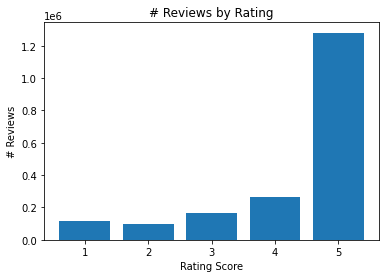

In [ ]:
# Classes (negative, neutral, positive) are not balanced for classification models.
plt.bar(df_ratings.index, df_ratings['verified'])
plt.title('# Reviews by Rating')
plt.xlabel('Rating Score')
plt.ylabel('# Reviews')
plt.show()

In [ ]:
df_eda['overall'].value_counts()

5.0    1280636
4.0     266797
3.0     164660
1.0     118491
2.0      97843
Name: overall, dtype: int64

In [ ]:
# Set sample size to lower than lowest count in overall scores.
sample_size = 25000

df = pd.DataFrame()
for i in df_eda['overall'].unique():
  X = df_eda[df_eda['overall'] == i].sample(sample_size)
  df = df.append(X)

In [ ]:
# Create time column using reviewTime data
df['time'] = df.reviewTime.str.replace(',', "")
df['time'] = pd.to_datetime(df['time'], format = '%m %d %Y')

# Drop reviewTime column
df = df.drop('reviewTime', axis = 1)
df.head(5)

,overall,verified,reviewerID,asin,reviewText,unixReviewTime,time
707378,3.0,True,A1P6621ULQ0H69,B0013MVJPY,it was pretty good when we first got it but th...,1341619200,2012-07-07
948461,3.0,True,A21TMM8NQOLA79,B00361YH5O,"My dogs love this toy, but they were able to t...",1395187200,2014-03-19
236073,3.0,True,A20DV9ZFNETN6Z,B00062KOTO,The quality of these kennels has gone down. I'...,1362614400,2013-03-07
212222,3.0,True,A2HF9XEVTZCT5,B0002J1F76,Bought this product but my animals are still i...,1393459200,2014-02-27
1183219,3.0,True,A10H3V8WYL6MKX,B006JVPUUY,it's very cheaply made and already coming apar...,1361577600,2013-02-23


# NLP - Machine Learning with Word2Vec

In [ ]:
### Helper variables and functions

def convert_sentiments(rating):
    if rating > 3:
        return 2            # Positive = 2
    elif rating == 3:
        return 1            # Neutral = 1
    else: # rating < 3:
        return 0           # Negative = 0

lemmatizer = WordNetLemmatizer()
stops = stopwords.words('english') + [string.punctuation]

def preprocess_text(text):
  stopwords_en=stopwords.words('english')
  lemmatizer=WordNetLemmatizer()
  tokenizer=TweetTokenizer()
  reconstructed_list=[]
  for each_text in text: 
      lemmatized_tokens=[]
      tokens=tokenizer.tokenize(each_text.lower())
      pos_tags=pos_tag(tokens)
      for each_token, tag in pos_tags: 
          if tag.startswith('NN'): 
              pos='n'
          elif tag.startswith('VB'): 
              pos='v'
          else: 
              pos='a'
          lemmatized_token=lemmatizer.lemmatize(each_token, pos)
          lemmatized_tokens.append(lemmatized_token)
      reconstructed_list.append(' '.join(lemmatized_tokens))
  return reconstructed_list

In [ ]:
df_ml = df.copy()
df_ml['sentiments'] = df_ml['overall'].apply(convert_sentiments)

# Create train and test data
train_df, test_df = train_test_split(df_ml, test_size = 0.2, random_state=42)
X_train = train_df['reviewText']
y_train = train_df['sentiments']
X_test = test_df['reviewText']
y_test = test_df['sentiments']
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (100000,)
y_train shape: (100000,)
X_test shape: (25000,)
y_test shape: (25000,)


In [ ]:
X_train=preprocess_text(X_train)
X_test=preprocess_text(X_test)

# Copies for reset point reference purposes, as preprocessing takes a long time
X_train1 = X_train
X_test1 = X_test

In [ ]:
# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train1)

# For later as model parameter
vocab_size=len(tokenizer.word_index)+1
max_len = max([len(sentence.split()) for sentence in df_ml['reviewText']])

# -> Sequences + Padding
X_train=pad_sequences(tokenizer.texts_to_sequences(X_train1), maxlen=max_len)
X_test=pad_sequences(tokenizer.texts_to_sequences(X_test1), maxlen=max_len)


In [ ]:
# Categorizing data for the keras model later
y_train1=to_categorical(y_train)
y_test1=to_categorical(y_test)

# Create Word2Vec Model

In [ ]:
clean_text = []
reviewText = df_ml['reviewText'].values.tolist()

for l in reviewText:
  # Tokenize
  tokens = nltk.word_tokenize(l)
  # Remove stop words + punctuation
  clean_tokens = [token.lower() for token in tokens if token.lower() not in stops]
  clean_tokens = [token for token in clean_tokens if token.isalpha()]
  clean_text.append(clean_tokens)


In [ ]:
# Size of vectors
EMBED_DIM = 100

w2v_model = Word2Vec(sentences=clean_text, size=EMBED_DIM, seed=42, window=5, workers=5, min_count=1)

In [ ]:
# Create embedding matrix with word index
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 5, EMBED_DIM))

for word, i in word_index.items():
  if i < (len(word_index) + 5):
    embedding_vector = w2v_model.wv[word]
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Train on sequential model that is woefully untuned and contains several bad choices like using a sigmoid function, which is for binary classification unlike our case in which our sentiments have 3 values - positive, neutral, and negative. 

In [ ]:
model = Sequential()
embedding_layer = Embedding(embeddings.shape[0], embeddings.shape[1], weights=[embeddings], input_length=length_long_sentence, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [ ]:
y_train2 = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test2 = np.asarray(y_test).astype('float32').reshape((-1,1))

model.fit(X_train, y_train2, epochs=5)

y_pred_test=model.predict(X_test)
y_pred_test = (y_pred_test>.5)*1
print(accuracy_score(y_test2,y_pred_test))

# Build Embedding Layer Model

Since we have 3 classes, 'softmax' is chosen as the activation function and the Dense output layer is adjusted to have dimension of x, 2 (x being the length of the y data fed in). My understanding is Bidirectional LTSM looks at both path and future context and could provide more insightful data.

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2209, 100)         3477900   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 3,713,681
Trainable params: 3,713,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train1, batch_size=250, epochs=20, validation_split=0.2)

Epoch 1/20
400/400 [==============================] - 184s 433ms/step - loss: 1.2835 - accuracy: 0.4315 - val_loss: 1.1564 - val_accuracy: 0.4977
Epoch 2/20
400/400 [==============================] - 172s 429ms/step - loss: 1.1047 - accuracy: 0.5215 - val_loss: 1.1250 - val_accuracy: 0.5114
Epoch 3/20
400/400 [==============================] - 173s 433ms/step - loss: 1.0362 - accuracy: 0.5557 - val_loss: 1.1276 - val_accuracy: 0.5114
Epoch 4/20
400/400 [==============================] - 176s 441ms/step - loss: 0.9743 - accuracy: 0.5874 - val_loss: 1.1365 - val_accuracy: 0.5106
Epoch 5/20
400/400 [==============================] - 171s 427ms/step - loss: 0.9142 - accuracy: 0.6178 - val_loss: 1.1594 - val_accuracy: 0.5120
Epoch 6/20
400/400 [==============================] - 176s 441ms/step - loss: 0.8594 - accuracy: 0.6459 - val_loss: 1.2017 - val_accuracy: 0.5037
Epoch 7/20
400/400 [==============================] - 171s 427ms/step - loss: 0.7988 - accuracy: 0.6741 - val_loss: 1.2569 -

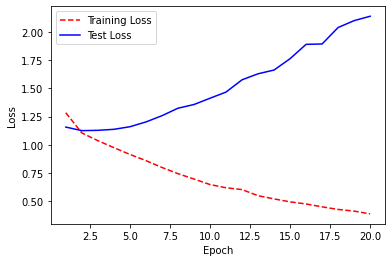

In [ ]:
# Reference credit: https://chrisalbon.com/code/deep_learning/keras/visualize_loss_history/ 

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
# Attach back to time 
y_pred = model.predict(X_test)

782/782 [==============================] - 63s 80ms/step


TypeError: ignored

# Visualize results - Scrapped; 
It's likely recommended to try fixing the overfitting problem first than analyze inaccurate data. However, there may not be enough time to resolve the issue as each fitting is taking (on my laptop) a minimum of 5 hours to run.

In [ ]:
time_test_df = test_df.copy()
time_test_df['predictions'] = [np.mean(lst) for lst in y_pred]

I want to look for any observable patterns of sentiment over time for products. However, our dataset is quite large, so maybe we can look at the products that are most/least reviewed and most/least liked.

In [ ]:
# Create df grouped by 'asin' to find which producst are most and least reviewed
asin_df = time_test_df.groupby('asin').count()

# Choose top 5 products
top_5 = asin_df.sort_values('overall', ascending=False).index[:5]

# Choose bottom 5 products
bot_5 = asin_df.sort_values('overall', ascending=True).index[:5]

In [ ]:
plt_test_df = time_test_df.groupby('asin').agg({'predictions':lambda x: list(x)})
plt_test_df['date'] = time_test_df.groupby('asin').agg({'time':lambda x: list(x)})['time'].values
plt_test_df = plt_test_df.reset_index()

,asin,predictions,date
0,6041026433,[0.19999997317790985],[2016-10-27 00:00:00]
1,6162622851,"[0.19999998807907104, 0.20000000298023224, 0.2...","[2018-02-16 00:00:00, 2017-12-15 00:00:00, 201..."
2,9822497938,[0.20000000298023224],[2016-06-05 00:00:00]
3,9828377403,[0.20000000298023224],[2016-03-18 00:00:00]
4,B00004T2WR,[0.19999998807907104],[2016-06-16 00:00:00]
...,...,...,...
11077,B01HHUAUBO,[0.20000000298023224],[2017-09-04 00:00:00]
11078,B01HI8IJ04,[0.19999997317790985],[2017-01-25 00:00:00]
11079,B01HI8UQ5K,[0.20000000298023224],[2017-03-14 00:00:00]
11080,B01HI97HAG,[0.19999998807907104],[2018-04-18 00:00:00]


In [ ]:
# Plot helper function 
colors = ['r', 'b', 'm', 'g', 'y']

def color_dict(asins):
  c_dict = {}
  i = 0
  for a in asins:
    c_dict[a] = colors[i]
    i += 1
  return c_dict


In [ ]:
mini_1 = plt_test_df.loc[plt_test_df['asin'].isin(top_5)]
mini_1 = mini_1.explode(['predictions', 'date']).reset_index(drop=True)
mini_1['year'] = pd.DatetimeIndex(mini_1['date']).year
mini_1 = mini_1.drop(['date'], axis=1)

fig, ax = plt.subplots()
color_top5 = color_dict(top_5)
for key, grp in mini_1.groupby(['asin']):
    ax = grp.plot(ax=ax, kind='dot', x='year', y='predictions', c=color_top5[key], label=key)

plt.legend(loc='best')
plt.show()

,asin,predictions,year
0,B000W5QSYA,0.2,2017
1,B000W5QSYA,0.2,2014
2,B000W5QSYA,0.2,2014
3,B000W5QSYA,0.2,2017
4,B000W5QSYA,0.2,2017
...,...,...,...
623,B001A5IXRG,0.2,2016
624,B001A5IXRG,0.2,2014
625,B001A5IXRG,0.2,2017
626,B001A5IXRG,0.2,2015
